In [1]:
from imputationLibrary import forwardFilling, hotDeck, meanImputation, movingAverage, splineInterpolation, separate, randomSampleImputation
from imputationLibrary.util import util
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from tsmoothie.smoother import *
import matplotlib.pyplot as plt

In [2]:
INPUT = 'output/\CompleteWeeklyIndexes'

In [3]:
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)
df_test = df.loc['2015-01-02':] #Selecting test data
df_train = df.loc['2000-01-01':'2015-01-01'] #Selecting training data

In [4]:
df_white_noise, df_seasonal, df_trended, df_trend_and_seasonal = separate.separate(df_train)

Could not determine nature of the feature trade_Trade Policy EMV Fraction and it will be assigned to a group randomly.


In [5]:
# infectious_daily_infect_emv_index, trade_US Trade Policy Uncertainty
df_white_noise.columns

Index(['vix_Volume', 'infectious_daily_infect_emv_index',
       'trade_Trade Policy EMV Fraction'],
      dtype='object')

In [6]:
df_seasonal.columns

Index([], dtype='object')

In [7]:
# sp500_Close, sp500_Volume, vix_Close, vix_Volume, 'dji_Close', 'dji_Volume', 'ndx_Close',
#       'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume',
#       'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume','trade_Trade Policy EMV Fraction'
df_trended.columns

Index(['hsi_Close'], dtype='object')

In [8]:
# GPR, trade_Japanese Trade Policy Uncertainty, trade_US Trade Policy Uncertainty
df_trend_and_seasonal.columns

Index(['sp500_Close', 'sp500_Volume', 'vix_Close', 'dji_Close', 'dji_Volume',
       'ndx_Close', 'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close',
       'ftse_Volume', 'hsi_Volume', 'n100_Close', 'n100_Volume',
       'Overall EMV Tracker', 'GPR', 'trade_US Trade Policy Uncertainty',
       'trade_Japanese Trade Policy Uncertainty'],
      dtype='object')

In [9]:
df_seasonal_train, df_seasonal_test = randomSampleImputation.input(df.loc['2000-01-01':'2015-01-01', df_seasonal.columns], df.loc['2015-01-02':, df_seasonal.columns], sliding_window_size = 0.03)

In [10]:
df_white_noise_train, df_white_noise_test =  meanImputation.input(df.loc['2000-01-01':'2015-01-01', df_white_noise.columns], df.loc['2015-01-02':, df_white_noise.columns])

In [11]:
df_trended_train, df_trended_test =  forwardFilling.input(df.loc['2000-01-01':'2015-01-01', df_trended.columns], df.loc['2015-01-02':, df_trended.columns])

In [12]:
df_trend_and_seasonal_train, df_trend_and_seasonal_test =  splineInterpolation.input(df.loc['2000-01-01':'2015-01-01', df_trend_and_seasonal.columns], df.loc['2015-01-02':, df_trend_and_seasonal.columns])

In [13]:
df_train = pd.concat([df_seasonal_train, df_white_noise_train, df_trended_train, df_trend_and_seasonal_train], axis=1, join='outer')

In [14]:
df_seasonal_test.index = df_white_noise_test.index

In [15]:
df_test = pd.concat([df_seasonal_test, df_white_noise_test, df_trended_test, df_trend_and_seasonal_test], axis=1, join='outer')

In [16]:
# Subsample para weekly

# Generating weekly sampled dataset
def generate_weekly(df, initial_friday):
    df_friday = initial_friday #datetime(2000,1,7)

    df_weekly = pd.DataFrame(columns = df.columns)
    
    while df_friday <= df.tail(1).index:
        df_weekly = df_weekly.append(df.loc[df_friday])
        df_friday+=timedelta(days=7)
    return df_weekly

In [17]:
### USE KALMAN FILTER TO SMOOTH ALL DATA (ONLY VISUALIZATION PURPOSE) ###

smoother_train = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother_train.smooth(df_train.T)

smoother_test = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother_test.smooth(df_test.T)

<tsmoothie.smoother.KalmanSmoother>

C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


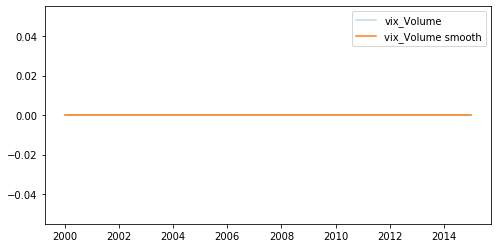

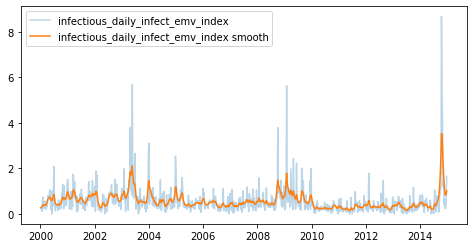

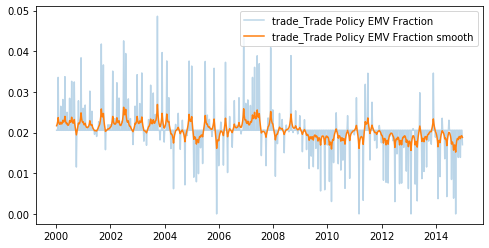

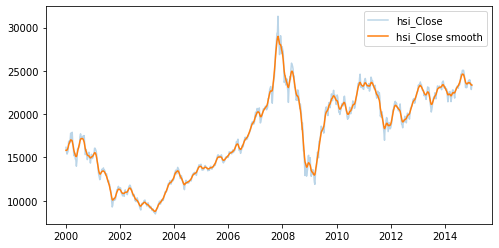

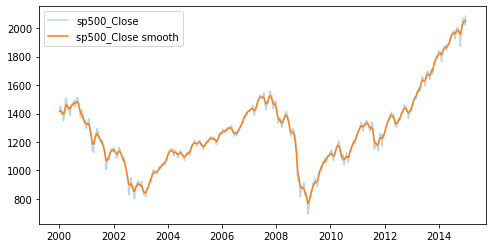

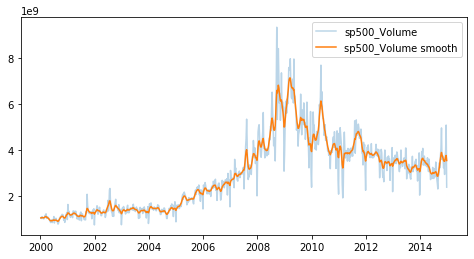

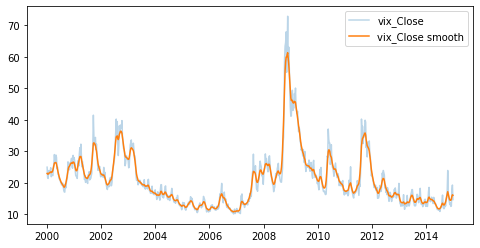

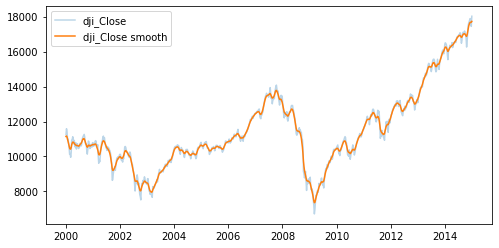

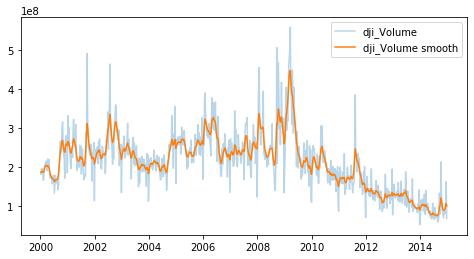

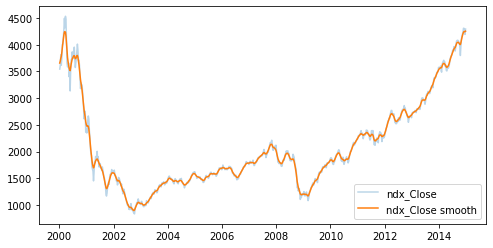

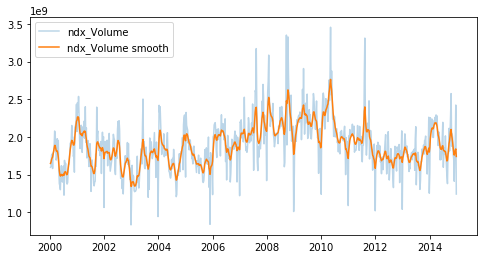

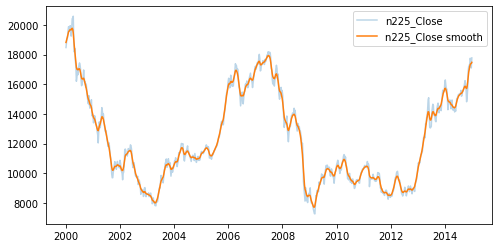

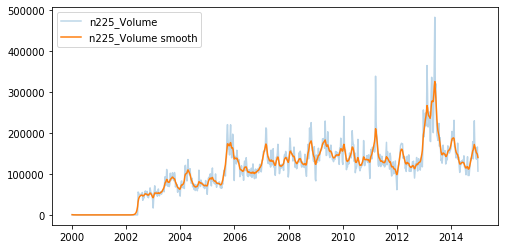

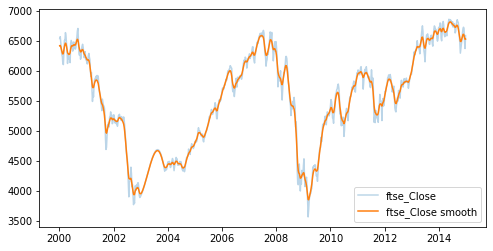

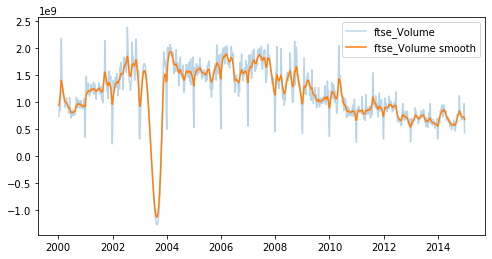

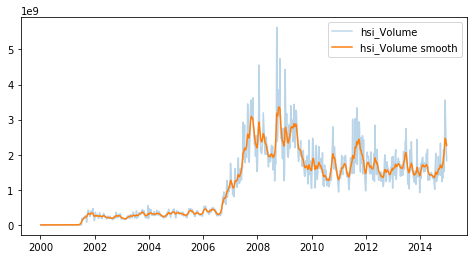

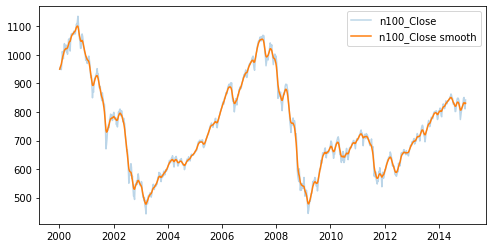

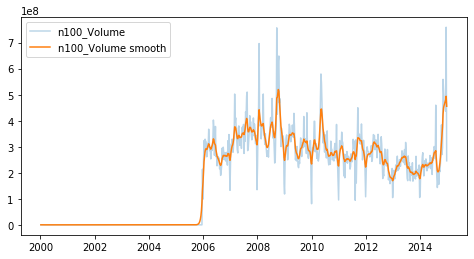

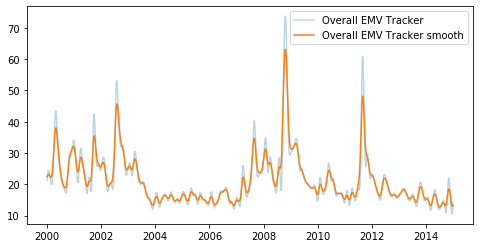

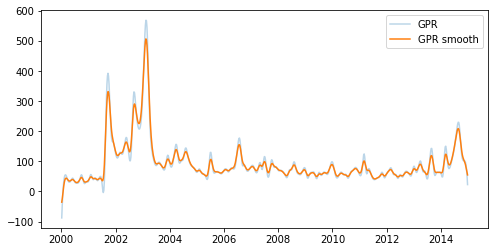

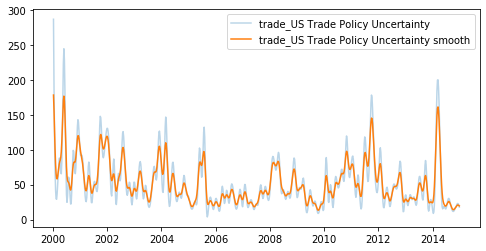

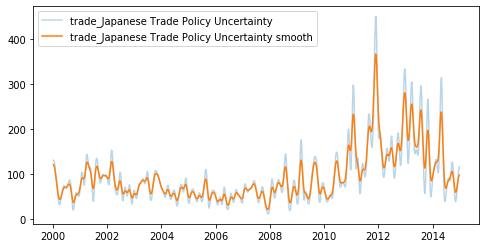

In [18]:
for i, name in enumerate(df_train.columns):
    plt.figure(figsize=(8,4))
    plt.plot(df_train.index, smoother_train.data[i], label=name, alpha=0.3)
    plt.plot(df_train.index, smoother_train.smooth_data[i], label=name+' smooth')
    plt.legend(); plt.show()

In [19]:
df_train = pd.DataFrame(data = smoother_train.smooth_data.T, index = df_train.index, columns= df_train.columns)
df_test = pd.DataFrame(data = smoother_test.smooth_data.T, index = df_test.index, columns= df_test.columns)

In [20]:
df_train_weekly = generate_weekly(df_train, datetime(2000,1,7))
df_test_weekly = generate_weekly(df_test, datetime(2015,1,2))

In [21]:
df_test_weekly.shape

(273, 22)

In [22]:
df_test.head()

,vix_Volume,infectious_daily_infect_emv_index,trade_Trade Policy EMV Fraction,hsi_Close,sp500_Close,sp500_Volume,vix_Close,dji_Close,dji_Volume,ndx_Close,...,n225_Volume,ftse_Close,ftse_Volume,hsi_Volume,n100_Close,n100_Volume,Overall EMV Tracker,GPR,trade_US Trade Policy Uncertainty,trade_Japanese Trade Policy Uncertainty
2015-01-02,0.0,2.057402,0.019230,23806.415239,2035.020606,3.389148e+09,18.198747,17615.431705,9.221211e+07,4203.510187,...,130133.113578,6539.478288,6.112278e+08,1.816853e+09,846.441296,4.983528e+08,4.260494e+99,1.044271e+100,1.139678e+91,1.634686e+91
2015-01-09,0.0,1.612191,0.019025,23935.317473,2035.207933,3.568900e+09,18.414302,17616.372985,9.694083e+07,4202.906584,...,135759.002153,6563.823312,6.660989e+08,1.848435e+09,852.621379,5.283159e+08,2.777194e+99,6.807061e+99,7.411697e+90,1.063090e+91
2015-01-16,0.0,1.386589,0.018513,24104.467481,2036.141236,3.687636e+09,18.513870,17616.073249,1.003690e+08,4207.427386,...,139848.655069,6609.694553,7.018707e+08,1.780342e+09,865.687530,5.537257e+08,1.825529e+99,4.474476e+99,4.854706e+90,6.963301e+90
2015-01-23,0.0,1.271852,0.017590,24261.013986,2041.264994,3.732544e+09,18.114549,17638.063051,1.024328e+08,4224.853694,...,141069.416749,6677.990653,7.166415e+08,1.758541e+09,882.804262,5.744363e+08,1.215203e+99,2.978532e+99,3.214628e+90,4.610870e+90
2015-01-30,0.0,1.087366,0.016073,24411.991723,2046.108909,3.752409e+09,17.745811,17659.509138,1.037750e+08,4241.632814,...,144433.656198,6739.079440,7.215604e+08,1.669261e+09,899.326537,5.727219e+08,8.240334e+98,2.019755e+99,2.163251e+90,3.102838e+90


In [23]:
df_train_weekly.to_csv(r'output\/CompleteIndexesWeeklyTrainNatureKalman.csv', index = True)
df_test_weekly.to_csv(r'output\/CompleteIndexesWeeklyTestNatureKalman.csv', index = True)

In [24]:
df

,sp500_Close,sp500_Volume,vix_Close,vix_Volume,dji_Close,dji_Volume,ndx_Close,ndx_Volume,n225_Close,n225_Volume,...,hsi_Close,hsi_Volume,n100_Close,n100_Volume,Overall EMV Tracker,infectious_daily_infect_emv_index,GPR,trade_US Trade Policy Uncertainty,trade_Japanese Trade Policy Uncertainty,trade_Trade Policy EMV Fraction
2000-01-07,1420.333984,1.068760e+09,25.016000,0.0,11250.781836,1.825620e+08,3542.894043,1.598166e+09,18476.772461,0.000000,...,16169.606250,0.000000e+00,949.868006,0.000000e+00,NaN,0.252857,NaN,NaN,NaN,NaN
2000-01-14,1448.648023,1.033940e+09,21.684000,0.0,11587.958008,1.962560e+08,3611.343994,1.609134e+09,18829.544922,0.000000,...,15720.128125,0.000000e+00,957.357996,0.000000e+00,NaN,0.214286,NaN,NaN,NaN,NaN
2000-01-21,1449.492493,1.113750e+09,21.447500,0.0,11413.272461,1.975950e+08,3810.092468,1.753105e+09,19083.530078,0.000000,...,15392.563867,0.000000e+00,958.146008,0.000000e+00,NaN,0.110000,NaN,NaN,NaN,NaN
2000-01-28,1394.874023,1.106420e+09,23.960000,0.0,10967.587890,1.956360e+08,3616.111963,1.772902e+09,19141.585938,0.000000,...,15560.411914,0.000000e+00,948.610010,0.000000e+00,24.412899,0.490000,NaN,71.914247,117.577146,0.033573
2000-02-04,1412.439990,1.041000e+09,23.014001,0.0,10992.404102,1.768760e+08,3744.364014,1.581506e+09,19618.308203,0.000000,...,15736.035157,0.000000e+00,969.562000,0.000000e+00,NaN,0.741429,34.391162,NaN,NaN,NaN
2000-02-11,1416.323975,1.020160e+09,22.886000,0.0,10726.277930,1.666060e+08,4004.691992,1.784898e+09,19883.024902,0.000000,...,16818.415528,0.000000e+00,1012.094006,0.000000e+00,NaN,0.311429,NaN,NaN,NaN,NaN
2000-02-18,1382.802002,1.023060e+09,23.996000,0.0,10506.685938,1.837200e+08,4014.451953,1.799752e+09,19620.780078,0.000000,...,16900.180469,0.000000e+00,999.685999,0.000000e+00,NaN,0.235714,NaN,NaN,NaN,NaN
2000-02-25,1349.912506,1.063475e+09,24.832500,0.0,10121.330078,2.031000e+08,4142.712402,1.858660e+09,19568.640234,0.000000,...,16642.794141,0.000000e+00,986.443994,0.000000e+00,NaN,0.315714,NaN,NaN,NaN,NaN
2000-03-03,1376.918018,1.170760e+09,21.992000,0.0,10167.401953,2.076680e+08,4283.041895,2.078572e+09,19950.787500,0.000000,...,17043.903906,0.000000e+00,1018.281995,0.000000e+00,19.913437,0.561429,54.098793,50.352413,58.499365,0.026471
2000-03-10,1382.071972,1.161580e+09,22.616000,0.0,9952.522266,2.117760e+08,4493.422070,2.038220e+09,19784.024219,0.000000,...,17808.887500,0.000000e+00,1039.794019,0.000000e+00,NaN,0.348571,NaN,NaN,NaN,NaN
